Our goal is to calculate the ideal number of PCA components on our train embeddings to reduce dimension/runtime while maintaining a high accuracy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
y_train_llm: (1222641,)
y_test_llm: (523989,)


PCA components:   0%|          | 0/96 [00:00<?, ?it/s]

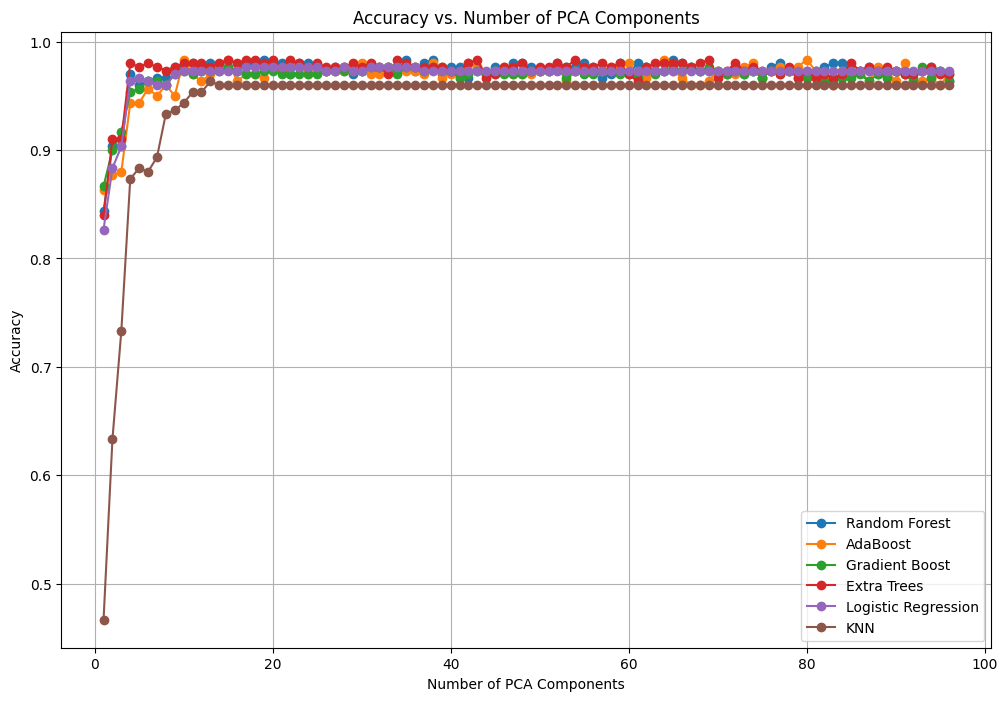

Optimal number of PCA components for Random Forest: 19
Optimal number of PCA components for AdaBoost: 10
Optimal number of PCA components for Gradient Boost: 15
Optimal number of PCA components for Extra Trees: 15
Optimal number of PCA components for Logistic Regression: 17
Optimal number of PCA components for KNN: 13


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Paths to your data
emtrainpath = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/xml/embeddings_train_xml.npy'
emtestpath = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/xml/embeddings_test_xml.npy'

# Import libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# Load embeddings
embeddings_train = np.load(emtrainpath)
embeddings_test = np.load(emtestpath)

# Load labels
ytrainpath = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/xml/y_train_llm.csv'
ytestpath = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/xml/y_test_llm.csv'
y_train_llm = pd.read_csv(ytrainpath)
y_test_llm = pd.read_csv(ytestpath)
y_train_llm = y_train_llm.iloc[:, 1].values
y_test_llm = y_test_llm.iloc[:, 1].values

print('y_train_llm:', y_train_llm.shape)
print('y_test_llm:', y_test_llm.shape)

# Sample 1000 indices from the training data with an even distribution of 0s and 1s
sample_size = 1000
positive_indices = np.where(y_train_llm == 1)[0]
negative_indices = np.where(y_train_llm == 0)[0]

positive_sample_size = int(sample_size / 2)
negative_sample_size = sample_size - positive_sample_size

positive_sample_indices = np.random.choice(positive_indices, positive_sample_size, replace=False)
negative_sample_indices = np.random.choice(negative_indices, negative_sample_size, replace=False)

sample_indices = np.concatenate((positive_sample_indices, negative_sample_indices))

embeddings_sample = embeddings_train[sample_indices]
labels_sample = y_train_llm[sample_indices]

# Perform a 70/30 train-test split on the sampled data
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    embeddings_sample, labels_sample, test_size=0.3, random_state=42
)

# List of models to evaluate
models = [RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), ExtraTreesClassifier(), SVC(), LogisticRegression(), KNeighborsClassifier()]
model_names = ['Random Forest', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']

# Function to train and evaluate models
def predicting_anomaly(X_train, X_test, y_train, y_test, models, names):
    scores = []
    for model, name in zip(models, names):
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score = accuracy_score(y_test, pred)
        scores.append(score)
    return scores

# Dictionary to store the accuracy scores
accuracy_scores = {}

# Loop through different numbers of PCA components
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_sample)
n_components_range = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.99)[0][0] + 1

for n_components in tqdm(range(1, n_components_range + 1), desc='PCA components'):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_sample)
    X_test_pca = pca.transform(X_test_sample)

    scores = predicting_anomaly(X_train_pca, X_test_pca, y_train_sample, y_test_sample, models, model_names)
    accuracy_scores[n_components] = scores

# Plot the accuracy scores
plt.figure(figsize=(12, 8))
for i, name in enumerate(model_names):
    model_scores = [scores[i] for scores in accuracy_scores.values()]
    plt.plot(range(1, n_components_range + 1), model_scores, marker='o', label=name)

plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of PCA Components')
plt.legend()
plt.grid()
plt.show()

# Find and print the optimal number of components for each model
optimal_components = {name: max(accuracy_scores.keys(), key=lambda x: accuracy_scores[x][i]) for i, name in enumerate(model_names)}
for name, n_components in optimal_components.items():
    print(f'Optimal number of PCA components for {name}: {n_components}')
